## Importing Libraries

In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# from keras.preprocessing.text import Tokenizer

import joblib

from wordcloud import WordCloud
from collections import Counter

# Data Proprocessing

## Loading Data

Load the data, and have an overview of the data

In [2]:
data = pd.read_csv('Suicide_Detection.csv')

print(data.head(),"\n")
print(data.info(),"\n")
print("Shape: ",data.shape)

# Convert string to 0/1 values
data['suicide'] = data['class'].apply(lambda x: 1 if x == 'suicide' else 0)

   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB
None 

Shape:  (232074, 3)


The column 'Unnammed: 0' is a meaningless column at here, thus we can delete it

In [3]:
data.drop(columns = 'Unnamed: 0', inplace=True)
data.head()

,text,class,suicide
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1
1,Am I weird I don't get affected by compliments...,non-suicide,0
2,Finally 2020 is almost over... So I can never ...,non-suicide,0
3,i need helpjust help me im crying so hard,suicide,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1


Check is null value available

In [4]:
data.isnull().sum()

text       0
class      0
suicide    0
dtype: int64

### Features Engineering

In [5]:
data['total_words'] = data['text'].apply(lambda x: len(x.split()))
data.head()

,text,class,suicide,total_words
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1,143
1,Am I weird I don't get affected by compliments...,non-suicide,0,27
2,Finally 2020 is almost over... So I can never ...,non-suicide,0,26
3,i need helpjust help me im crying so hard,suicide,1,9
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1,438


## Data Visualization

Proportion of suicide and non-suicide thoughts

1    116037
0    116037
Name: suicide, dtype: int64


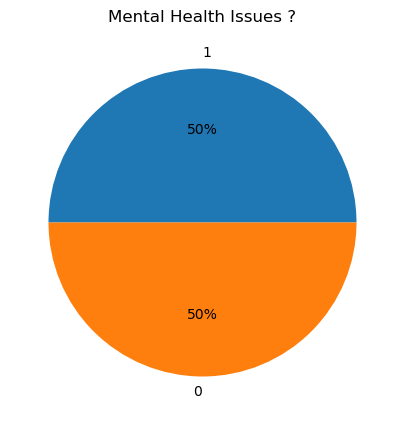

In [6]:
classCount = data["suicide"].value_counts()
print(classCount)

plt.figure(figsize=((15,5)))

plt.subplot(1,2,2)
plt.title('Mental Health Issues ?')
plt.pie(classCount,labels = classCount.index,autopct='%.0f%%')

plt.show()

## Text Processing

Lower Case, Remove Puncutuations, Remove Stop Words, Word Stemming

In [7]:
# Convert texts to lower case
data['text'] = data['text'].str.lower()

# Remove punctuations
data['text'] = data['text'].str.replace(r'[^\w\s]+','',regex=True)

# Remove stop words
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Tokenize the words
data['text'] = data['text'].apply(lambda x:nltk.word_tokenize(x))

In [8]:
# Stemming the words
ps = PorterStemmer()
data['text'] = data['text'].apply(lambda x: [ps.stem(i) for i in x])

# Combine the stemmed words
data['text'] = data['text'].apply(lambda x: ' '.join(x))

data.head()

,text,class,suicide,total_words
0,ex wife threaten suiciderec left wife good che...,suicide,1,143
1,weird dont get affect compliment come someon k...,non-suicide,0,27
2,final 2020 almost never hear 2020 bad year eve...,non-suicide,0,26
3,need helpjust help im cri hard,suicide,1,9
4,im losthello name adam 16 ive struggl year im ...,suicide,1,438


### Words Frequency

show words commonly used when expressing suicidal thought

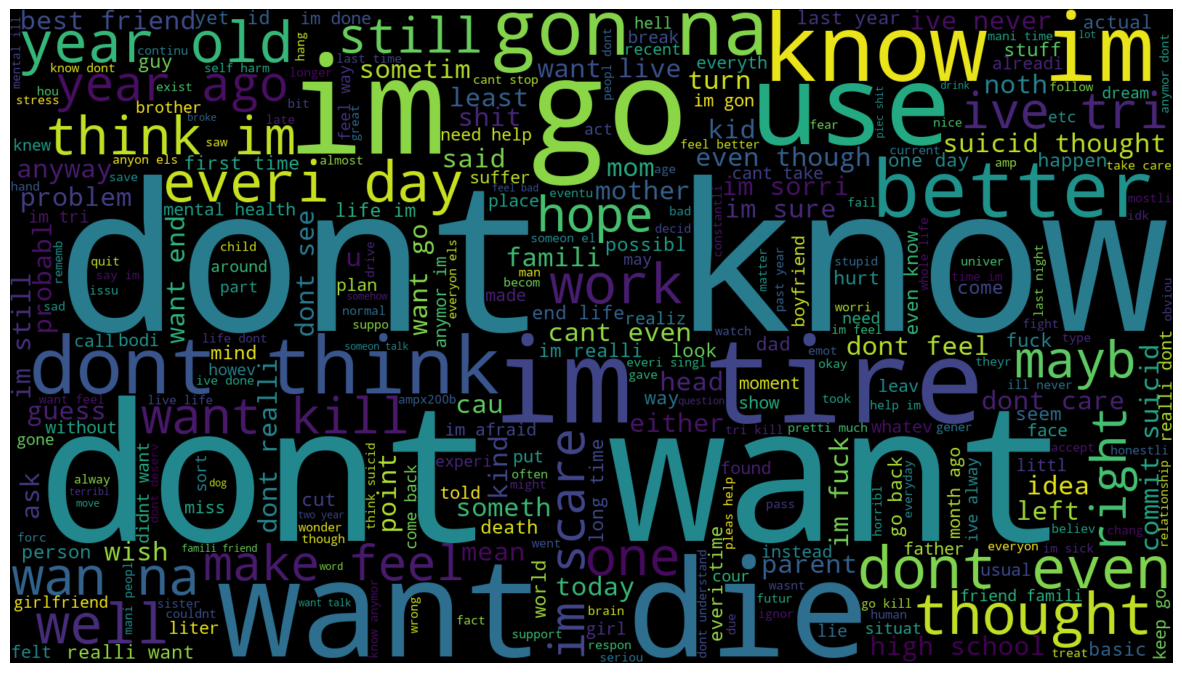

In [10]:
# Use wordcloud to generate a grap
text = " ".join(data[data['suicide'] == 1]['text'])
plt.figure(figsize=(15,10))
wordcloud = WordCloud(max_words = 300, height = 900, width = 1600, background_color='black', colormap = 'viridis').generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

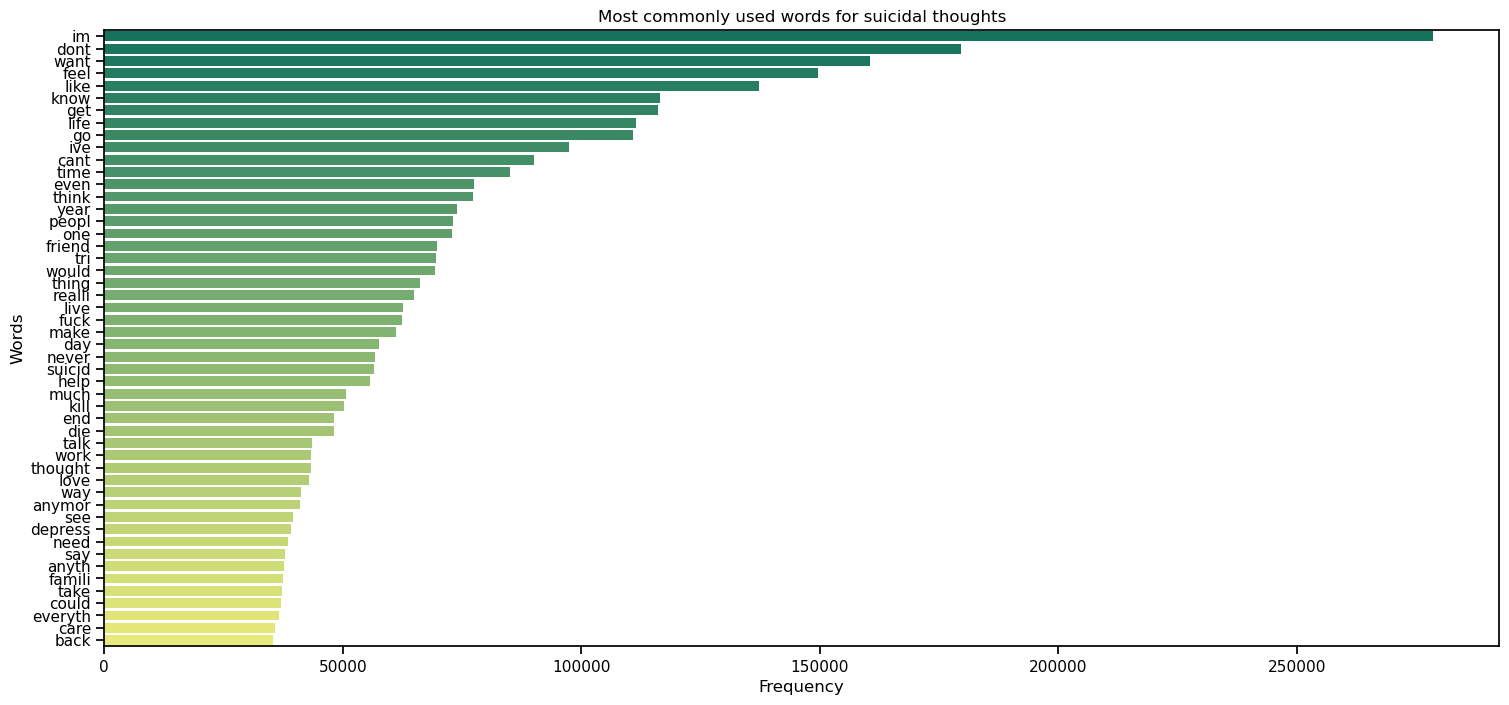

In [12]:
depression_words_ranking = []
for sentence in data[data['suicide'] == 1]['text'].to_list():
    for word in sentence.split():
        depression_words_ranking.append(word)
        
df = pd.DataFrame(Counter(depression_words_ranking).most_common(50),columns=['Word','Frequency'])

sns.set_context('notebook')
plt.figure(figsize=(18,8))
sns.barplot(y=df['Word'], x=df['Frequency'],palette='summer')
plt.title('Most commonly used words for suicidal thoughts')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()


### Lemmatization

In [ ]:
def lemmatize(text,pos='v'):
    return ' '.join([lemmatizer.lemmatize(word,pos=pos) for word in word_tokenize(text)])

lemmatizer = WordNetLemmatizer()

lemmatized = ' '.join([lemmatizer.lemmatize(word, pos='v') for word in word_tokenize(text)])

lemmatized

# data.head()

## Split Data

In [13]:
x,y = data['text'],data['suicide']

vectorizer = TfidfVectorizer(min_df=50,max_features=5000)
x = vectorizer.fit_transform(x).toarray()

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=3)
X_train.shape, X_test.shape

((185659, 5000), (46415, 5000))

# Models Predictions

## Naive Bayes

In [ ]:
naive_bayes_gaussian = GaussianNB()
naive_bayes_bernoulli = BernoulliNB()
naive_bayes_multinomial = MultinomialNB()

VotingClassifiers = VotingClassifier(
    estimators=[
        ('GaussianNB',naive_bayes_gaussian),
        ('Bernoulli',naive_bayes_bernoulli),
        ('Multinomial',naive_bayes_multinomial)
    ],voting='soft'
)

VotingClassifiers.fit(X_train,y_train)

nb_prediction = VotingClassifiers.predict(X_test)
nb_confussion_matrix = confusion_matrix(y_test,nb_prediction)
nb_accuracy = accuracy_score(y_test,nb_prediction)

# Score for Training
print("Training Score = ",VotingClassifiers.score(X_train,y_train))

# Score for Testing
print("Testing Score = ",VotingClassifiers.score(X_test,y_test))

print("Confussion Matrix : ", nb_confussion_matrix)
print(classification_report(y_test,nb_prediction))

## Random Forest

In [ ]:
# random_forest_classifier = RandomizedSearchCV(
#     RandomForestClassifier(),
#     {
#         'n_estimators':[4,5],
#         'criterion':['entropy'],
#         'max_depth':range(1,4),'min_samples_split':range(2,5)
#     }, random_state=10
# )

random_forest_classifier = RandomForestClassifier(n_estimators=100)

random_forest_classifier.fit(X_train,y_train)

# Score for Training
print("Training Score = ",random_forest_classifier.score(X_train,y_train))

# Score for Testing
print("Testing Score = ",random_forest_classifier.score(X_test,y_test))

## Decision Tree

In [ ]:
decision_tree_classifier = DecisionTreeClassifier(criterion='gini',splitter='random',min_samples_leaf=100,max_depth=6,random_state=0)
decision_tree_classifier.fit(X_train,y_train)
                             
# Score for Training
print("Training Score = ",decision_tree_classifier.score(X_train,y_train))
                             
# Score for Testing
print("Testing Score = ",decision_tree_classifier.score(X_test,y_test))

# Conclusion

In [ ]:
model_ev = pd.DataFrame({
    'Model':['Naive Bayes','Random Forest','Decision Tree'],
    'Accuracy':[nb_accuracy,nb_accuracy,nb_accuracy]
})

model_ev

Naive Bayes is the best fit model for the given dataset as it has the values,
- Training Score: 0.9024567408018418
- Testing Score =  0.8993723338551916

### Save Model

In [ ]:
joblib.dump(VotingClassifiers,'naive_bayes_model.joblib')

In [ ]:
def preprocess(word):
    word = word.lower()
    word = word.replace(r'[^\w\s]+','')
    word = [word for word in word.split() if word not in (stop_words)]
    word = ' '.join([ps.stem(i) for i in word])
    return vectorizer.transform([word]).toarray()

def mental_health_issue_detector(text):
    print("Input = ",text)
    processed_word = preprocess(text)
    prediction = VotingClassifiers.predict(processed_word)
    print(prediction[0])

## User Input

In [ ]:
mental_health_issue_detector("love")